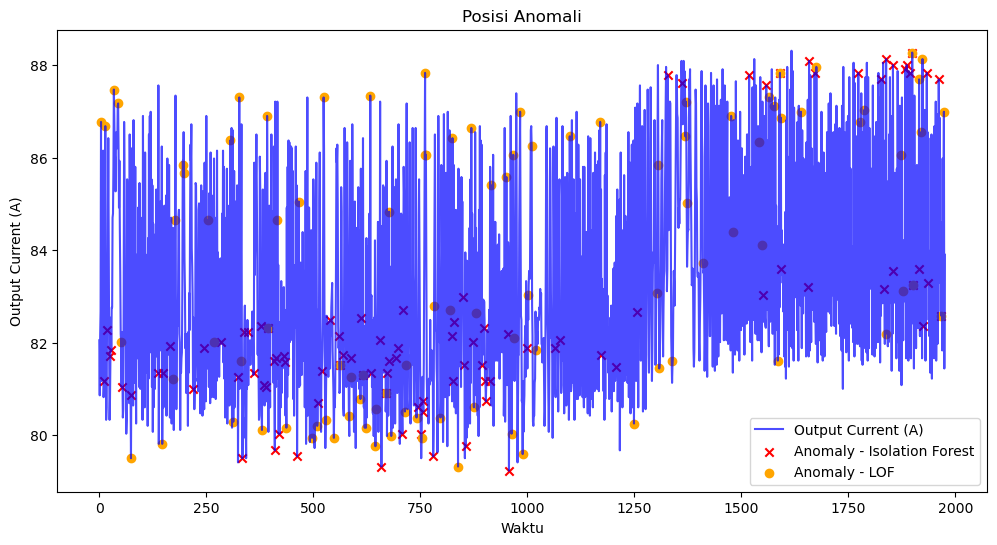

Isolation Forest mendeteksi 99 anomali dari 1976 data (5.01%)
LOF mendeteksi 99 anomali dari 1976 data (5.01%)
Contoh Data Anomali:
      Output Frequency  Output Current  Output Voltage  Output Power  \
12               48.15           81.17           370.8          39.4   
18               48.17           82.27           371.0          38.1   
26               48.14           81.70           370.8          42.6   
28               48.17           81.83           371.0          38.9   
52               48.16           81.04           371.0          38.8   
...                ...             ...             ...           ...   
1924             48.17           82.36           371.2          39.3   
1933             48.16           87.83           371.2          47.5   
1936             48.16           83.29           371.1          39.2   
1961             48.16           87.69           371.3          47.6   
1967             48.16           82.58           371.1          47.3   

   

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# === 1. Load Data ===
file_path = "SP1_new.CSV" 
df = pd.read_csv(file_path)

# Kolom baru
df['RPM Ref'] = df['Frequency Reference'] * 120 / 2
df['RPM Out'] = df['Output Frequency'] * 120 / 2
df['Power Factor'] = (df['Output Power'] * 1000) / (np.sqrt(3) * df['Output Voltage'] * df['Output Current'])
df['Slip (%)'] = (abs(df['RPM Out'] - df['RPM Ref']) / df['RPM Out']) * 100
df['Apparent Power (kVA)'] = (np.sqrt(3) * df['Output Voltage'] * df['Output Current']) / 1000
df['Efficiency (%)'] = 93.5
df['Daya Output Motor (kW)'] = (np.sqrt(3) * df['Output Voltage'] * df['Output Current'] * df['Efficiency (%)'] / 100 * df['Power Factor']) / 1000
df['Torque (Nm)'] = 9555*df['Daya Output Motor (kW)']/df['RPM Out']
df

# === 2. Pilih Fitur & Target ===
features = [
    "Output Frequency", "Output Current", "Output Voltage",
    "Output Power", "Power Factor", "Daya Output Motor (kW)", "Torque (Nm)"
]  
data = df[features].dropna()

# === 3. Normalisasi Data ===
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# === 4. Deteksi Anomali dengan Isolation Forest ===
iso_forest = IsolationForest(n_estimators=200, contamination=0.05, random_state=42)
data["IsoForest_Score"] = iso_forest.fit_predict(data_scaled)

# === 5. Deteksi Anomali dengan Local Outlier Factor (LOF) ===
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
data["LOF_Score"] = lof.fit_predict(data_scaled)

# === 6. Identifikasi Anomali ===
data["Anomaly_IsoForest"] = data["IsoForest_Score"] == -1
data["Anomaly_LOF"] = data["LOF_Score"] == -1

# === 7. Visualisasi Hasil Deteksi Anomali ===
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Output Current"], label="Output Current (A)", color="blue", alpha=0.7)

# Anomali dari Isolation Forest
plt.scatter(data.index[data["Anomaly_IsoForest"]],
            data["Output Current"][data["Anomaly_IsoForest"]],
            color="red", marker="x", label="Anomaly - Isolation Forest")

# Anomali dari LOF
plt.scatter(data.index[data["Anomaly_LOF"]],
            data["Output Current"][data["Anomaly_LOF"]],
            color="orange", marker="o", label="Anomaly - LOF")

plt.xlabel("Waktu")
plt.ylabel("Output Current (A)")
plt.title("Posisi Anomali")
plt.legend()
plt.show()

# === 8. Persentase Anomali ===
anomali_iso = data["Anomaly_IsoForest"].sum()
anomali_lof = data["Anomaly_LOF"].sum()
total_data = len(data)

print(f"Isolation Forest mendeteksi {anomali_iso} anomali dari {total_data} data ({anomali_iso/total_data:.2%})")
print(f"LOF mendeteksi {anomali_lof} anomali dari {total_data} data ({anomali_lof/total_data:.2%})")

# Menampilkan beberapa data yang terdeteksi sebagai anomali
print("Contoh Data Anomali:")
print(data[data["Anomaly_IsoForest"]])

In [11]:
print("Contoh Data Anomali:")
print(data[data["Anomaly_LOF"]])

Contoh Data Anomali:
      Output Frequency  Output Current  Output Voltage  Output Power  \
4                48.17           86.77           371.1          45.7   
14               48.18           86.68           371.2          46.4   
34               48.18           87.47           371.3          45.7   
44               48.16           87.17           371.1          44.3   
51               48.16           82.01           370.9          41.1   
...                ...             ...             ...           ...   
1915             48.17           87.69           371.4          46.4   
1920             48.16           86.55           371.3          45.3   
1923             48.15           88.13           371.2          46.5   
1967             48.16           82.58           371.1          47.3   
1973             48.16           86.99           371.3          45.8   

      Power Factor  Daya Output Motor (kW)  Torque (Nm)  IsoForest_Score  \
4         0.819398                 42.

In [12]:
# === 8. Filter Data yang Diteteksi Anomali oleh Kedua Model ===
anomali_bersama = data[(data["Anomaly_IsoForest"]) & (data["Anomaly_LOF"])]
print
# Menampilkan data yang dianggap anomali oleh kedua model
print("Data yang Ditemukan Anomali oleh Isolation Forest dan LOF:")
anomali_bersama


Data yang Ditemukan Anomali oleh Isolation Forest dan LOF:


,Output Frequency,Output Current,Output Voltage,Output Power,Power Factor,Daya Output Motor (kW),Torque (Nm),IsoForest_Score,LOF_Score,Anomaly_IsoForest,Anomaly_LOF
394,48.18,82.32,371.1,38.4,0.725729,35.9040,118.673973,-1,-1,True,True
563,48.17,81.52,371.1,47.1,0.898887,44.0385,145.591263,-1,-1,True,True
617,48.18,81.30,371.1,38.3,0.732920,35.8105,118.364926,-1,-1,True,True
670,48.14,80.91,370.8,37.0,0.712031,34.5950,114.442330,-1,-1,True,True
1590,48.17,87.83,371.2,48.1,0.851792,44.9735,148.682372,-1,-1,True,True
1899,48.18,88.27,371.3,47.3,0.833225,44.2255,146.179138,-1,-1,True,True
1901,48.16,83.24,371.2,47.3,0.883813,44.2255,146.239844,-1,-1,True,True
1967,48.16,82.58,371.1,47.3,0.891117,44.2255,146.239844,-1,-1,True,True
